In [83]:
import numpy as np
import math
import random
import matplotlib.pyplot as plt

### Initial state

In [84]:
m = 10 # Количество частей файла (скачиваются по порядку. У лича >= 1 части, у сида все m частей)
n, l = 2 * (m + 1), m + 2 # количество видов узлов и возможных взаимодействий между ними

def get_alpha():
    lichers = np.array([m * 2 if i == 0 or i == m else m - i for i in range(m + 1)]) # количество личей с i частями файла
    lichers_ = np.append(np.cumsum(lichers[::-1]
            )[:-1:][::-1], 0) # количество подходящих для лича узлов для передачи файла (для новых клиентов - все личи + сиды)
    alpha = np.append(lichers, lichers_)
    return alpha

lichers = np.array([m * 2 if i == 0 or i == m else m - i for i in range(m + 1)]) # количество личей с i частями файла
lichers_ = np.append(np.cumsum(lichers[::-1]
            )[:-1:][::-1], 0) # количество подходящих для лича узлов для передачи файла (для новых клиентов - все личи + сиды)
alpha = np.append(lichers, lichers_)

lmb = 1
delta = sum(lichers_)
mu = 0.03
phi = ([lmb] +
       [lichers_[i] * lichers[i] / delta for i in range(m)] +
       [mu*lichers[-1]])

eps = np.array([[0 for i in range(m + 1)] + [0 for i in range(m + 1)]] +
               [[1 if i == j else 0 for i in range(m + 1)] + [1 if i == j else 0 for i in range(m + 1)] for j in range(m)] +
               [[1 if i == m else 0 for i in range(m + 1)] + [0 for i in range(m + 1)]])

p_gamma = np.array([[1 if i == 0 else 0 for i in range(m + 1)] + [0 for i in range(m + 1)]] +
                   [[1 if i == j + 1 else 0 for i in range(m + 1)] + [2 if i == j else 0 for i in range(m + 1)] for j in range(m)] +
                   [[0 for i in range(m + 1)] + [0 for i in range(m + 1)]])

In [85]:
print("eps:", eps)
print("phi:", phi)
print("p_gamma:", p_gamma)
print("lichers:", lichers)
print("lichers_:", lichers_)
print("alpha:", alpha)

eps: [[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]]
phi: [1, 3.5616438356164384, 1.3808219178082193, 1.0520547945205478, 0.7863013698630137, 0.5753424657534246, 0.410958904109589, 0.28493150684931506, 0.18904109589041096, 0.11506849315068493, 0.0547945205479452, 0.6]
p_gamma: [[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0

### Process

In [86]:
def inverse_exp(random_, coef):
    '''Возвращает значение случайной величины,
    распределённой по экспоненциальному закону,
    соответствующему простейшему Пуассоновскому потоку
    с \lambda = coef
    :param coef: параметр \lambda показательного закона
    :param random_: число из генератора случайных чисел от 0 до 1
    :return: реализация случайной величины, распределенной по показательному закону
    с параметром \lambda'''
    if coef == 0:
        return np.finfo(np.float32).max
    return -1/coef * math.log(1 - random_)

def inverse_exp_det(coef):
    '''Возвращает матожидание случайной величины,
    распределённой по экспоненциальному закону,
    соответствующему простейшему Пуассоновскому потоку
    с \lambda = coef
    :param coef: параметр \lambda показательного закона
    :return: матожидание случайной величины, распределенной по показательному закону
    с параметром \lambda'''
    if coef == 0:
        return np.finfo(np.float32).max
    return 1/coef

tau = np.array([0 for _ in range(l)], dtype=np.float32) # время следующего события i
for i in range(l):
    tau[i] = inverse_exp(random.random(), phi[i])

def update_tau(tau, ):
    ''' Возвращает матрицу с временами событий на следующем шаге и ближайшее событие
    :param tau: array of trigger times, generated on the previous step
    :return: times array on the next step, next event, time of next event'''
    min_ = np.finfo(np.float32).max
    idx_min = 0

    for k in range(len(tau)):
        if tau[k] == np.finfo(np.float32).max and phi[k] != 0:
            tau[k] = inverse_exp(random.random(), phi[k])
        if tau[k] < min_:
            min_ = tau[k]
            idx_min = k
    tau -= min_
    return tau, idx_min, min_

def update_tau_det(tau, ):
    ''' Возвращает матрицу с временами событий на следующем шаге и ближайшее событие
    :param tau: array of trigger times, generated on the previous step
    :return: times array on the next step, next event, time of next event'''
    min_ = np.finfo(np.float32).max
    idx_min = 0

    for k in range(len(tau)):
        if tau[k] == np.finfo(np.float32).max and phi[k] != 0:
            tau[k] = inverse_exp_det(phi[k])
        if tau[k] < min_:
            min_ = tau[k]
            idx_min = k
    tau -= min_
    return tau, idx_min, min_

def update_lichers_(lichers):
    return np.append(np.cumsum(lichers[::-1] 
            )[:-1:][::-1], 0)

def update_lichers(alpha):
    return alpha[:len(lichers)]

def update_phi(alpha):
    phi = np.array([lmb] +
                   [lichers_[i] * lichers[i] / delta for i in range(m)] +
                   [mu*lichers[-1]])
    phi[~np.all(eps <= alpha, axis=1)] = 0
    return phi

def taking_action(alpha, next_event):
    """Совершаем следующее предопределённое действие
    :param alpha: array of existing particles
    :param next_event: next event with prerequisites from eps and consequences determined from p_gamma
    :return: next state and new probabilities of events"""
    alpha += -eps[next_event] + p_gamma[next_event]

    phi = update_phi(alpha)
    return alpha, phi

def plot_exponential_distributions(lambdas, x_max=10, num_points=1000, alphas: list[list[float]] = None):
    """
    Строит графики плотности вероятности (PDF) экспоненциальных распределений.

    Параметры:
    ----------
    lambdas : list of float
        Список параметров λ (лямбд) для экспоненциальных распределений.
    x_max : float, optional
        Максимальное значение по оси X (по умолчанию 10).
    num_points : int, optional
        Количество точек для построения графиков (по умолчанию 1000).
    """
    states = ["приход новых клиентов"] + [f"скачка {i + 1} части" for i in range(m)] + ["уход сидов"]
    plt.figure(figsize=(10, 6))
    x = np.linspace(0, x_max, num_points)

    for i, lam in enumerate(lambdas):
        if lam < 0:
            raise ValueError("Параметр λ должен быть положительным.")
        pdf = lam * np.exp(-lam * x)  # Формула PDF экспоненциального распределения
        plt.plot(x, pdf, label=f'λ = {lam:.2f}, {states[i]}')

    #plt.title(f'Плотность вероятности экспоненциального распределения,\n alpha = {alpha[:len(lichers)]}')
    plt.xlabel('x')
    plt.ylabel('PDF')
    plt.grid(True)
    plt.legend()
    plt.show()


<>:2: SyntaxWarning: invalid escape sequence '\l'
<>:15: SyntaxWarning: invalid escape sequence '\l'
<>:2: SyntaxWarning: invalid escape sequence '\l'
<>:15: SyntaxWarning: invalid escape sequence '\l'
C:\Users\User\AppData\Local\Temp\ipykernel_26972\3568452336.py:2: SyntaxWarning: invalid escape sequence '\l'
  '''Возвращает значение случайной величины,
C:\Users\User\AppData\Local\Temp\ipykernel_26972\3568452336.py:15: SyntaxWarning: invalid escape sequence '\l'
  '''Возвращает матожидание случайной величины,


### Running K steps

12 22
[20  9  8  7  6  5  4  3  2  1 20 65 56 48 41 35 30 26 23 21 20  0]
[1, 3.5616438356164384, 1.3808219178082193, 1.0520547945205478, 0.7863013698630137, 0.5753424657534246, 0.410958904109589, 0.28493150684931506, 0.18904109589041096, 0.11506849315068493, 0.0547945205479452, 0.6]


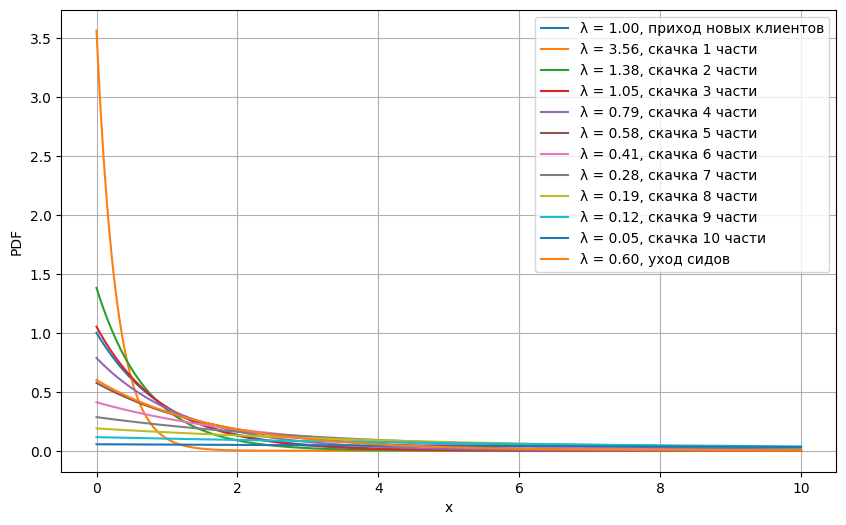

12 22
[ 7 15 15 10 10  2 10  1  4  2  8 89 74 59 49 39 37 27 26 22 20  0]
[1.         1.47671233 2.50684932 1.93150685 1.01369863 0.73972603
 0.1369863  0.4109589  0.03835616 0.10958904 0.04383562 0.24      ]


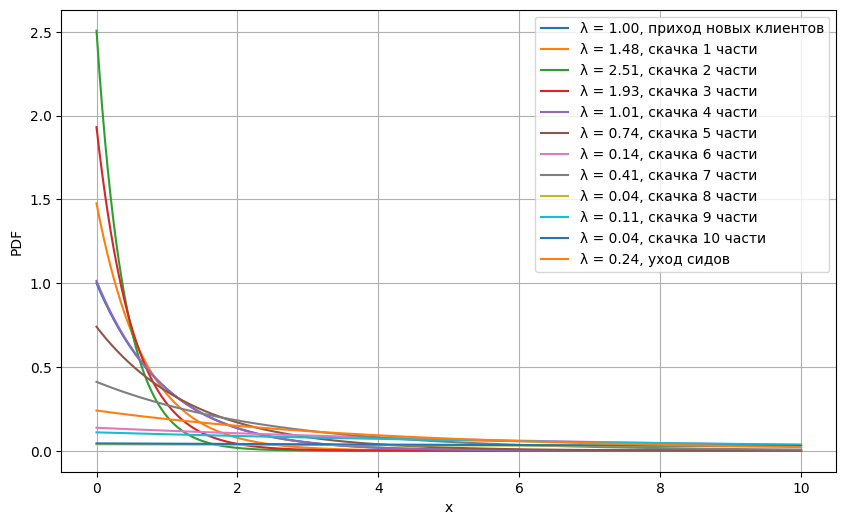

In [87]:
k = 400
particles_history = np.empty((k + 1, n))
times = np.empty(k + 1)
alpha = get_alpha()
particles_history[0, :] = alpha
times[0] = 0
print(len(phi), len(alpha))
print(alpha)
print(phi)
plot_exponential_distributions(lambdas=phi, alphas=alpha)
for i in range(1, k + 1):
    tau, next_event, delta_time = update_tau(tau)
    alpha, phi = taking_action(alpha, next_event)
    lichers = update_lichers(alpha)
    lichers_ = update_lichers_(lichers)
    tau[next_event] = inverse_exp(random.random(), phi[next_event])
    particles_history[i, :] = alpha
    times[i] = delta_time + times[i - 1]
    if i == 100:
        print(len(phi), len(alpha))
        print(alpha)
        print(phi)
        plot_exponential_distributions(lambdas=phi, alphas=alpha)
    #print(f"after {i} step:")
    #print("tau:", tau, "\nphi:", phi, "\nalpha:", alpha, "\nevent:", next_event)


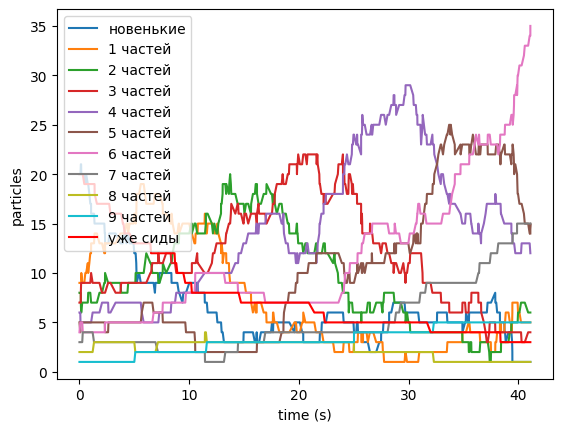

In [88]:
states = ["новенькие"] + [f"{i + 1} частей" for i in range(m - 1)] + ["уже сиды"]
def plot_particles_history(particles_history, times, title=None):
    for i in range(m + 1):
        if i == m:
            plt.plot(times, particles_history[:, i], label=f"{states[i]}", c="red")
        else:
            plt.plot(times, particles_history[:, i], label=f"{states[i]}")
    if title:
        plt.title(title)
    plt.xlabel("time (s)")
    plt.ylabel("particles")
    plt.legend()
    plt.show()
plot_particles_history(particles_history, times)

### Determinated process

[1.         3.56164384 1.38082192 1.05205479 0.78630137 0.57534247
 0.4109589  0.28493151 0.1890411  0.11506849 0.05479452 0.6       ]
tau: [ 0.7192308   0.29554656  0.4434371   0.6697516   0.9910078   1.457326
  2.152564    3.228846    5.0090857   8.409707   17.96923     1.3858974 ] 
phi: [1.         3.38356164 1.53424658 1.05205479 0.78630137 0.57534247
 0.4109589  0.28493151 0.1890411  0.11506849 0.05479452 0.6       ] 
alpha: [19 10  8  7  6  5  4  3  2  1 20 66 56 48 41 35 30 26 23 21 20  0] 
event: 1
tau: [ 0.4236842   0.30723906  0.14789054  0.37420502  0.6954613   1.1617795
  1.8570175   2.9332995   4.713539    8.114161   17.673683    1.0903509 ] 
phi: [1.         3.25479452 1.68767123 1.05205479 0.78630137 0.57534247
 0.4109589  0.28493151 0.1890411  0.11506849 0.05479452 0.6       ] 
alpha: [18 11  8  7  6  5  4  3  2  1 20 67 56 48 41 35 30 26 23 21 20  0] 
event: 1
tau: [ 0.27579367  0.15934852  0.65178573  0.22631449  0.5475707   1.013889
  1.709127    2.785409    4.565648

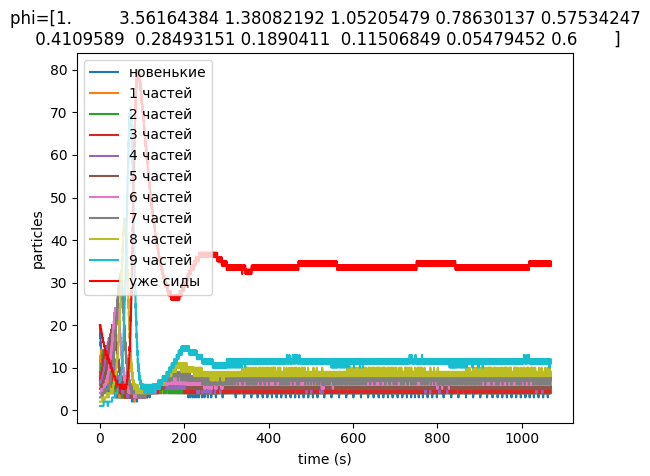

In [89]:
k = 13000
particles_history = np.empty((k + 1, n))
times = np.empty(k + 1)

alpha = get_alpha()
lichers = update_lichers(alpha)
lichers_ = update_lichers_(lichers)
phi = update_phi(alpha)

tau = np.array([0 for _ in range(l)], dtype=np.float32) # время следующего события i
for i in range(l):
    tau[i] = inverse_exp_det(phi[i])
particles_history[0, :] = alpha
times[0] = 0
print(phi)
for i in range(1, k + 1):
    tau, next_event, delta_time = update_tau_det(tau)
    alpha, phi = taking_action(alpha, next_event)
    lichers = update_lichers(alpha)
    lichers_ = update_lichers_(lichers)
    tau[next_event] = inverse_exp_det(phi[next_event])
    particles_history[i, :] = alpha
    times[i] = delta_time + times[i - 1]
    if i < 5:
        print("tau:", tau, "\nphi:", phi, "\nalpha:", alpha, "\nevent:", next_event)

alpha = get_alpha()
lichers = update_lichers(alpha)
lichers_ = update_lichers_(lichers)
phi = update_phi(alpha)
plot_particles_history(particles_history, times, title=f"phi={phi}")

### Obtaining trj trajectories with k steps

In [90]:
alpha = get_alpha()
lichers = update_lichers(alpha)
lichers_ = update_lichers_(lichers)

k = 400
trj = 1000
particles_history = np.empty((trj, k + 1, n))
times = np.empty((trj, k + 1))
particles_history[:, 0, :] = alpha
times[:, 0] = 0

for j in range(trj):
    alpha = get_alpha()
    lichers = update_lichers(alpha)
    lichers_ = update_lichers_(lichers)

    phi = ([lmb] +
       [lichers_[i] * lichers[i] / delta for i in range(m)] +
       [mu])

    tau = np.array([0 for _ in range(l)], dtype=np.float32) # время следующего события i
    for i in range(l):
        tau[i] = inverse_exp(random.random(), phi[i])


    for i in range(1, k + 1):
        tau, next_event, delta_time = update_tau(tau)
        alpha, phi = taking_action(alpha, next_event)
        lichers = update_lichers(alpha)
        lichers_ = update_lichers_(lichers)
        tau[next_event] = inverse_exp(random.random(), phi[next_event])
        particles_history[j, i, :] = alpha
        times[j, i] = delta_time + times[j, i - 1]
        #if j == 0 or j == 1 or j == 2:
            #print(f"after {i} step:")
            #print("tau:", tau, "\nphi:", phi, "\nalpha:", alpha, "\nevent:", next_event)

D:\PyCharmPrj\ML\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


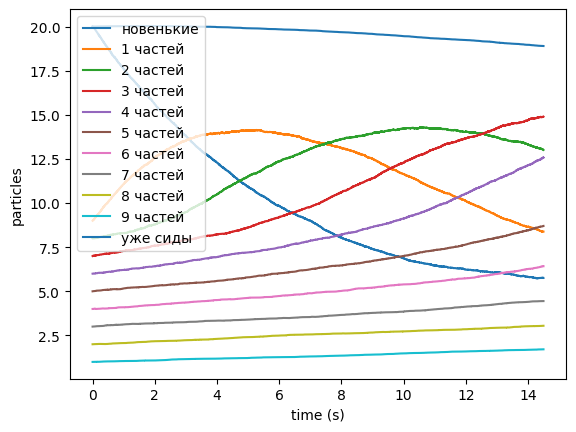

In [91]:
indices = np.ones(trj, dtype=int)
cum_indices = np.zeros(trj, dtype=int)
merged = [get_alpha()]
total_times = [0]

for i in range(trj * (k - 2)):
    idx_min = np.argmin(times[np.arange(trj), indices])
    cum_indices[idx_min] = min(cum_indices[idx_min] + 1, 200)
    indices[idx_min] = min(indices[idx_min] + 1, 200)

    merged.append(np.mean(particles_history[np.arange(trj), cum_indices, :], axis=0))
    total_times.append(times[idx_min, cum_indices[idx_min]])

merged = np.array(merged)[:, :m + 1]
plt.plot(total_times, merged, label=["новенькие"] + [f"{i + 1} частей" for i in range(m - 1)] + ["уже сиды"])
plt.xlabel("time (s)")
plt.ylabel("particles")
plt.legend()
plt.show()

In [92]:
print(tau)
print(eps)
print(p_gamma)
print(alpha)

[1.6097296e+00 1.2893593e+01 1.2414495e+00 9.3765378e-02 6.3778520e-01
 9.8979473e-02 2.2421889e+00 1.2595177e-02 3.9421916e-03 1.4011803e+00
 1.3108770e+01 3.4318604e+00]
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]]
[[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 0 